## BI Hausaufgabe 1: Kurts komplizierte Komplikation (kNN)
### Import der Programmbibliotheken

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

---
### Aufgabe (a) - Analyse nach CRISP-DM, Eigenschaften und Zusammenhänge der Variablen.
### Sind alle Variablen für die Anwendung eines k-NN Verfahrens notwendig bzw. geeignet? Wenn ja – Warum? Wenn nein – Warum?
---
1. Business Understanding:
Kurt hat das Problem, dass er meteorologische Daten der letzten zwei Jahre besitzt sowie die Freizeitaktivität, die er
mit seinen Freunden aufgrund des Wetters gewählt hat.
Ihm fehlt jedoch leider eine Methode zur Klassifikation von neuen Daten. Dadurch könnten neuen Daten direkt einer
Freizeitaktivität zugeordnet werden.
Daher soll im Folgenden ein geeigneter Algorithmus zur Klassifikation gefunden werden.

2. Data Understanding
Im Data Understanding Part widmen wir uns der Datenqualität. Dafür schauen wir uns zunächst die Skalierung an und
stellen fest, dass alle relevanten Daten keinen numerischen Datentyp besitzen. Um die Datenqualität jedoch zu bewerten,
benötigen wir im besten Falle Integers oder Floats - auf jeden Fall numerische Daten.
Um diese zu erhalten, benutzen wir den LabelEncoder, der die Daten auf ein adäquates Intervall transformiert. Man könnte
an dieser Stelle argumentieren, dass eine solche Transformation eher in eine andere Phase des CRISP-DM passt, ich finde
jedoch, dass die Datentransformation eine notwendige Voraussetzung ist, um beispielsweise die verschiedenen
Korrelationen zu betrachten. Daher habe ich die Transformation in dieser Phase vorgenommen.

Anschließend können wir uns ein Diagramm über die fehlenden Werte Anzeigen lassen und stellen fest, dass es keine gibt.
Nun können wir uns noch die Korrelationen ansehen und stellen fest, dass die relative Luftfeuchtigkeit relativ hoch mit
Schnee korreliert. Weiterhin fällt die negative Korrelation von Schnee mit der Temperatur auf. An dieser Stelle könnte
man daher überlegen, die Variable Schnee zu entfernen. Da die Korrelation jedoch nicht übermäßig hoch ist, lassen wir
Schnee im DataFrame. Die Korrelationen der einzelnen Variablen mit den verschiedenen Klassen machen keinen Sinn, weil
die Klassen in numerische Werte transformiert wurden, die Daten aber nominal skaliert sind.

Für einen kNN-Algorithmus ist jedoch die Variable id irrelevant, da sie keinerlei Aussagekraft für unser im Business
Understanding deklariertes Ziel enthält und lediglich zur Identifikation der einzelnen Messungen dient - was uns nicht
interessiert. Daher kann diese entfernt werden. Zudem macht das Datum für uns nur beschränkt Sinn, weil jede Tag-Monat-
Kombination bei einem Betrachtungszeitraum von zwei Jahren höchstens zweimal vorkommen kann. Zudem wurden die Messungen
nicht täglich durchgeführt, weshalb fast jede Tag-Monat-Kombination nur einmal vorkommt. Theoretisch könnten wir
mithilfe des intervallskalierten Datums jeder Messung eine Jahreszeit zuordnen, was die Datenbasis in vier gleichmäßig
verteilte Ausprägungen des Merkmals unterteilen würde. Der Einfachheit halber löschen wir die Variable Datum jedoch aus
dem Datensatz heraus. Die restlichen Variablen relative Luftfeuchtigkeit, Temperatur, Niederschlag und die Schneehöhe
machen alle Sinn und haben einen Einfluss auf die Klasse.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         105 non-null    int64 
 1   Datum                      105 non-null    object
 2   relative Luftfeuchtigkeit  105 non-null    object
 3   Temperatur                 105 non-null    object
 4   Niederschlag               105 non-null    object
 5   Schnee                     105 non-null    object
 6   Freizeitangebot            105 non-null    object
dtypes: int64(1), object(6)
memory usage: 5.9+ KB
None


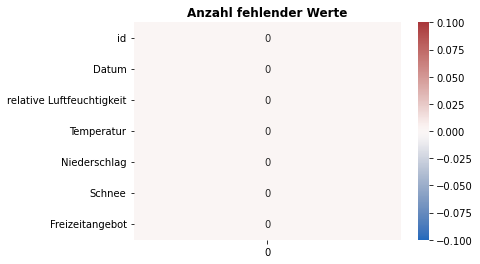

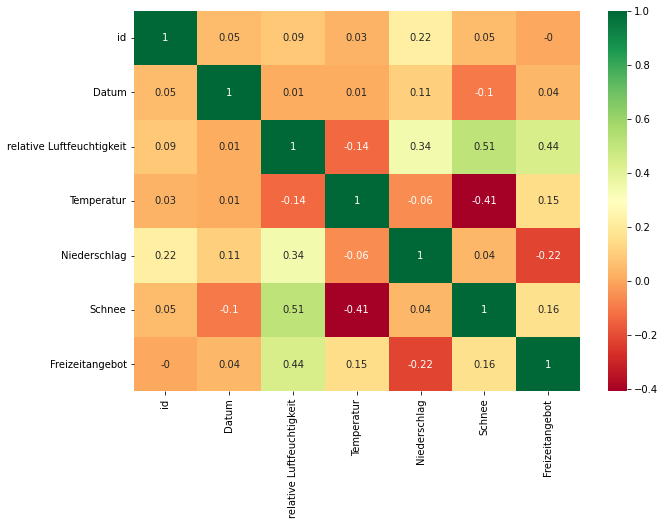

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Datum                      105 non-null    int32
 1   relative Luftfeuchtigkeit  105 non-null    int32
 2   Temperatur                 105 non-null    int32
 3   Niederschlag               105 non-null    int32
 4   Schnee                     105 non-null    int32
 5   Freizeitangebot            105 non-null    int32
dtypes: int32(6)
memory usage: 2.6 KB
None


In [16]:
df = pd.read_csv("Übungsblatt 1 - Daten_Projekt.csv", sep=";")  # Daten aus der csv als DataFrame Objekt instanziieren
print(df.info())  # Informationen zum DataFrame anzeigen

le = LabelEncoder()  # LabelEncoder Objekt instanziieren
for i in df.columns:  # über die sechs DataFrame Columns iterieren
    if i != "Freizeitangebot":  # außer Column Freizeitangebot
        df[i] = le.fit_transform(df[i])  # jede Column in numerische Werte transformieren

# Column Freizeitangebot besser manuell in numerische Werte überführen
df["Freizeitangebot"] = df["Freizeitangebot"].map({"Wandern" :0,
                                                   "Skifahren" :1,
                                                   "Lesen" :2,
                                                   "Fussball": 3,
                                                   "Baden": 4}).astype(int)

plt.title("Anzahl fehlender Werte", fontweight="bold")  # Titel für Diagramm festlegen
sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt="d", cmap="vlag")  # Diagramm über fehlende Werte erstellen
plt.show()  # Diagramm anzeigen

corr = df.drop(["Freizeitangebot"], axis=1).corr().round(2)  # Korrelationen aller DataFrame Columns erfassen
plt.figure(figsize=(10, 7))  # Diagrammeingenschaften festlegen
sns.heatmap(corr, annot=True, cmap='RdYlGn')  # Diagramm erstellen
plt.show()  # Diagramm anzeigen

df = df.drop(["id", "Datum"], axis=1)  # variable id kann vernachlässigt werden

print(df.info())  # zum Schluss nochmal eine Info anzeigen

3. Data Preparation
Im Bereich Data Preparation

In [12]:
ks = [1, 3, 5, 7, 9]
x = df.drop(["Freizeitangebot"], axis=1)  # Daten unserer Untersuchungsvariable als x festlegen
y = df["Freizeitangebot"]  # alle anderen Daten als y festlegen

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)  # aufteilen der Daten

for k in ks:  # über ide fünf verschiedenen Werte für k iterieren
    knn = KNeighborsClassifier(n_neighbors=k)  # kNN als Classifier Objekt mit k Nachbarn
    knn.fit(x_train, y_train)  # Trainingsdaten fitten
    print("\n" + "=" * 20 + f"kNN mit {k} Nachbarn" + "=" * 20)  # coole Zeile anzeigen
    y_pred = knn.predict(x_test)

    arg_test = {"y_true": y_test, "y_pred": y_pred}  # Variablen als dict erstellen zum späteren entpacken als parameter
    confusion = confusion_matrix(**arg_test)  # confusion matrix erstellen
    print(confusion)  # confusion matrix anzeigen
    classification = classification_report(**arg_test)  # classification report erstellen
    print(classification)  # classification report anzeigen

    print(f"Accuracy für k={k}: ", accuracy_score(y_test, knn.predict(x_test)).round(4))


====================kNN mit 1 Nachbarn====================
[[3 1 0 0 0]
 [0 5 1 0 2]
 [0 1 1 0 3]
 [0 0 0 1 1]
 [3 1 0 0 9]]
              precision    recall  f1-score   support

       Baden       0.50      0.75      0.60         4
    Fussball       0.62      0.62      0.62         8
       Lesen       0.50      0.20      0.29         5
   Skifahren       1.00      0.50      0.67         2
     Wandern       0.60      0.69      0.64        13

    accuracy                           0.59        32
   macro avg       0.65      0.55      0.56        32
weighted avg       0.60      0.59      0.58        32

Accuracy mit 1 Nachbarn:  0.5938

====================kNN mit 3 Nachbarn====================
[[3 1 0 0 0]
 [1 5 0 0 2]
 [0 1 1 0 3]
 [0 0 0 1 1]
 [6 0 1 0 6]]
              precision    recall  f1-score   support

       Baden       0.30      0.75      0.43         4
    Fussball       0.71      0.62      0.67         8
       Lesen       0.50      0.20      0.29         5
   Skifah